In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN.PINN import *
from NN_library.PINN.train_PINN import *
from matplotlib.tri import Triangulation
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

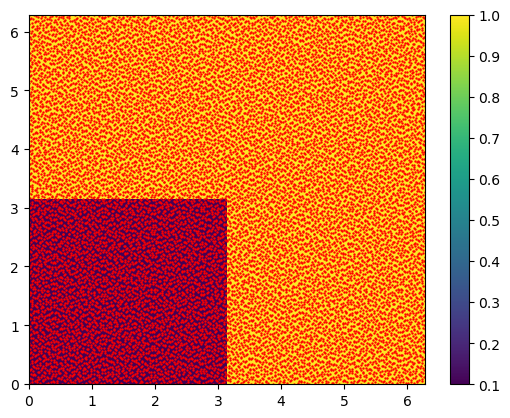

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
H1 = torch.tensor([1, 0], device=dev).view(1, 2) # macrogradient
H2 = torch.tensor([0, 1], device=dev).view(1, 2) # macrogradient
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x<np.pi)&(y<np.pi), 0.1, 1)
    return a

def A(x):
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = x[:,0]
    return H

def H2(x):
    H = torch.zeros_like(x)
    H[:,1] = x[:,1]
    return H

Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.5, c='r')

In [8]:
net_H1 = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_H1.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 10000, 'dev' : dev, 'name' : f'NN_library/PINN/PINN_H1_{total_params}'}

Number of parameters: 1801


In [5]:
net_H1 = load_network(net_H1, args['name']+'_9999', args)
net_H1 = net_H1.to(dev)

In [9]:
losses_train, losses_val = train(net_H1, loaders, args, A, H1)

Epoch: 0 mean train loss:  7.93896449e-01, mean val. rec. loss:  7.96256520e-01
Epoch: 1 mean train loss:  7.92855886e-01, mean val. rec. loss:  7.95221027e-01
Epoch: 2 mean train loss:  7.91826289e-01, mean val. rec. loss:  7.94196783e-01
Epoch: 3 mean train loss:  7.90807656e-01, mean val. rec. loss:  7.93183571e-01
Epoch: 4 mean train loss:  7.89799808e-01, mean val. rec. loss:  7.92181026e-01
Epoch: 5 mean train loss:  7.88802449e-01, mean val. rec. loss:  7.91188788e-01
Epoch: 6 mean train loss:  7.87815279e-01, mean val. rec. loss:  7.90206637e-01
Epoch: 7 mean train loss:  7.86837883e-01, mean val. rec. loss:  7.89234211e-01
Epoch: 8 mean train loss:  7.85870020e-01, mean val. rec. loss:  7.88271583e-01
Epoch: 9 mean train loss:  7.84911573e-01, mean val. rec. loss:  7.87318390e-01
Epoch: 10 mean train loss:  7.83962482e-01, mean val. rec. loss:  7.86374413e-01
Epoch: 11 mean train loss:  7.83022388e-01, mean val. rec. loss:  7.85439653e-01
Epoch: 12 mean train loss:  7.82091174

In [10]:
np.save(f'NN_library/training_data/PINN_H1_{total_params}', np.vstack([losses_train, losses_val]))

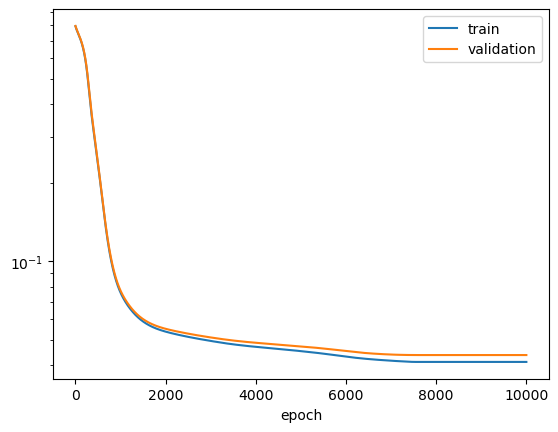

In [11]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [2]:
args = {'lr' : 0.0001, 'epochs' : 10000, 'dev' : dev, 'name' : f'NN_library/PINN/PINN_H2_{total_params}'}
net_H2 = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_H2.parameters())
print(f"Number of parameters: {total_params}")

NameError: name 'dev' is not defined

In [ ]:
net_H2 = load_network(net_H2, args['name']+'_9999', args)
net_H2 = net_H2.to(dev)

In [1]:
losses_train, losses_val = train(net_H2, loaders, args, A, H2)

NameError: name 'train' is not defined

In [13]:
np.save(f'NN_library/training_data/PINN_H2_{total_params}', np.vstack([losses_train, losses_val]))

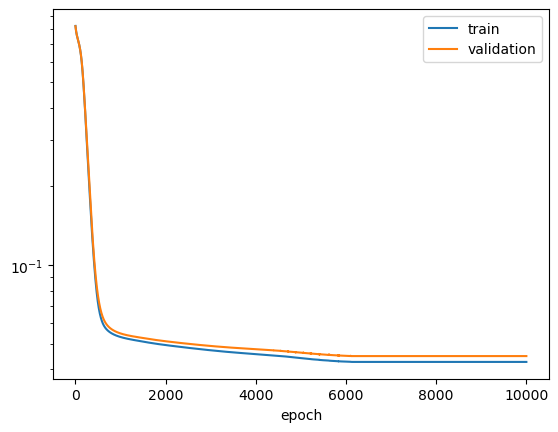

In [14]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [15]:
U1 = net_H1(grid_data).detach().cpu()
U2 = net_H2(grid_data).detach().cpu()

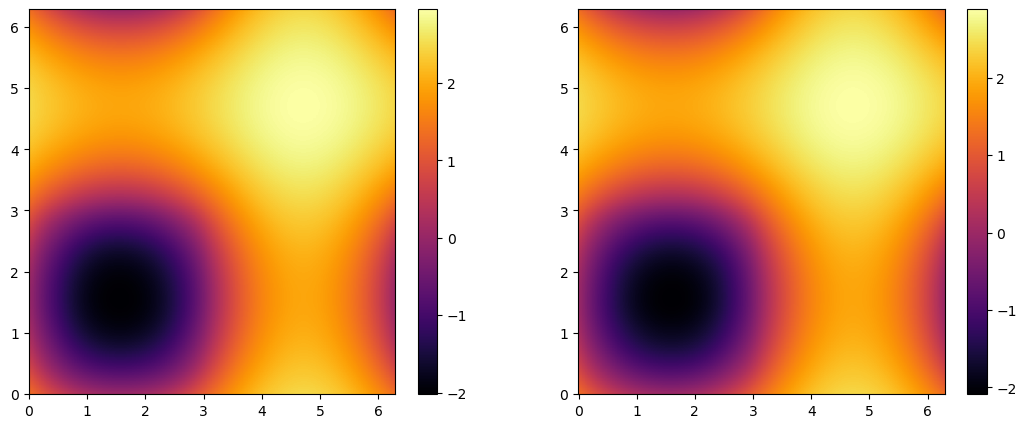

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])

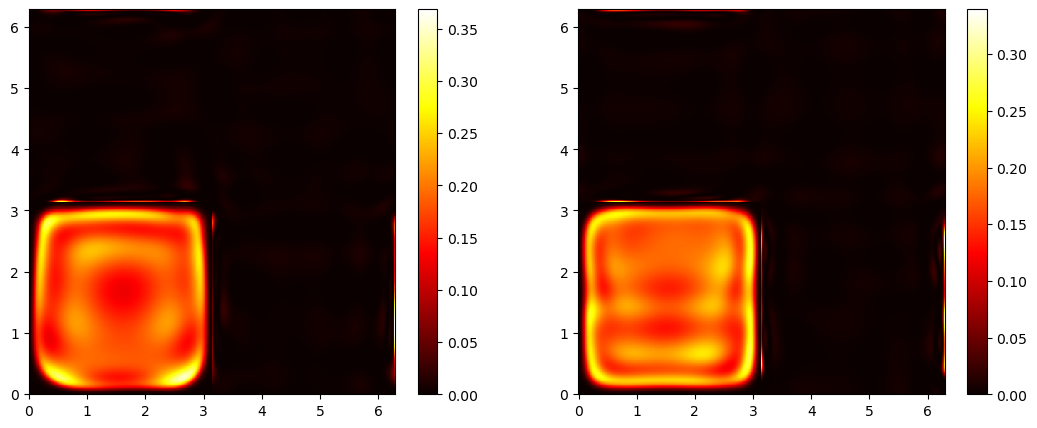

In [17]:
error_1 = PDE_loss(grid_data, net_H1, A, H1).detach().cpu()
error_2 = PDE_loss(grid_data, net_H2, A, H2).detach().cpu()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], error_1.reshape(N, N), cmap='hot')
#axs[0].scatter(data[:,0], data[:,1], s=0.5, c='g')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.reshape(N, N), cmap='hot')
#axs[1].scatter(data[:,0], data[:,1], s=0.5, c='g')
fig.colorbar(pos2, ax=axs[1])

In [18]:
inputs = data[:].to(dev).requires_grad_(True)
T1 = net_H1(inputs)
T2 = net_H2(inputs)
dq1 = torch.autograd.grad(
            outputs=T1, inputs=inputs,
            grad_outputs=torch.ones_like(T1)
    )[0].detach()
dq2 = torch.autograd.grad(
            outputs=T2, inputs=inputs,
            grad_outputs=torch.ones_like(T2)
    )[0].detach()
triang = Triangulation(data[:,0], data[:,1])
n_elem = len(triang.triangles)

In [19]:
def compute_bound(T1, T2, dq1, dq2, tri, data):
    # Compute the A_h
    A_h = np.zeros((2,2))
    A_h_linear = np.zeros((2,2))
    n_elem = len(tri.triangles)
    for i in range(n_elem):
        elem = tri.triangles[i]
        node_coords = data[elem]
        vector = node_coords[1:]-node_coords[:-1]
        vectors = torch.hstack((vector, torch.tensor([[0], [0]], device=dev)))
        area = 0.5 * abs(torch.cross(vectors[0], vectors[1])[-1])
        A_loc = A(node_coords)

        # use the gradients given by the NN
        d1_nn = dq1[elem]
        d2_nn = dq2[elem]
        Q1 = A_loc @ (d1_nn + H1(node_coords)).view(3,2,1)
        Q2 = A_loc @ (d2_nn + H2(node_coords)).view(3,2,1)
        Q1_mean = Q1.mean(dim=0)
        Q2_mean = Q2.mean(dim=0)
        A_h_elem_1 = (area * Q1_mean).squeeze().detach().cpu().numpy()
        A_h_elem_2 = (area * Q2_mean).squeeze().detach().cpu().numpy()
        A_h[:,0] += A_h_elem_1
        A_h[:,1] += A_h_elem_2

        # use the gradients given by the linear approximation
        M = torch.column_stack((torch.ones(3, device=dev), node_coords))
        M_inv = torch.linalg.inv(M)
        D_grad = M_inv[1:]
        U1 = T1[elem]
        U2 = T2[elem]
        d1 = D_grad @ U1
        d2 = D_grad @ U2
        Q1 = A_loc @ (d1.view(1,2) + H1(node_coords)).view(3,2,1)
        Q2 = A_loc @ (d2.view(1,2) + H2(node_coords)).view(3,2,1)
        Q1_mean = Q1.mean(dim=0)
        Q2_mean = Q2.mean(dim=0)
        A_h_elem_1 = (area * Q1_mean).squeeze().detach().cpu().numpy()
        A_h_elem_2 = (area * Q2_mean).squeeze().detach().cpu().numpy()
        A_h_linear[:,0] = A_h_linear[:,0] + A_h_elem_1
        A_h_linear[:,1] = A_h_linear[:,1] + A_h_elem_2
    return A_h/L**2, A_h_linear/L**2

In [20]:
A_bound = compute_bound(T1, T2, dq1, dq2, triang, inputs)
print(A_bound[0])
print(A_bound[1])

[[2.78919337e+00 2.05846904e-03]
 [8.30690079e-04 2.79026919e+00]]
[[ 2.72449052 -0.06248506]
 [ 0.13561947  2.92213484]]


In [ ]:
A_bound = compute_bound(T1, T2, dq1, dq2, triang, inputs)
print(A_bound[0])
print(A_bound[1])

[[2.78919337e+00 2.05846904e-03]
 [8.30690079e-04 2.79026919e+00]]
[[ 2.72449052 -0.06248506]
 [ 0.13561947  2.92213484]]


In [ ]:
np.save(f'bounds/linear/A_u_NN_{total_params}.npy', A_bound)